In [ ]:
from google.colab import files
files.upload()

Saving archive.zip to archive.zip
Buffered data was truncated after reaching the output size limit.

In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
!ls /content
!ls /content/train
!ls /content/test

archive.zip  sample_data  test	train
angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")


In [6]:
TRAIN_DIR = "/content/train"
TEST_DIR  = "/content/test"

IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64

EPOCHS = 20               # start lower
FINE_TUNING_EPOCHS = 10
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA = 3
SEED = 12

CLASS_LABELS = [
    'Anger', 'Disgust', 'Fear',
    'Happy', 'Neutral', 'Sadness', 'Surprise'
]


In [7]:
def get_data_generators():

    preprocess_fun = tf.keras.applications.densenet.preprocess_input

    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.05,
        validation_split=0.2,
        preprocessing_function=preprocess_fun
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fun
    )

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        subset="training",
        shuffle=True,
        seed=SEED
    )

    val_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        subset="validation",
        shuffle=True,
        seed=SEED
    )

    test_gen = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen, test_gen


In [8]:
def build_model():

    base_model = tf.keras.applications.DenseNet169(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [9]:
def get_class_weights(train_gen):
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    return dict(enumerate(weights))


In [10]:
def train_model(model, train_gen, val_gen, class_weights):

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=EARLY_STOPPING_CRITERIA,
        restore_best_weights=True
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[early_stop]
    )

    # Fine-tuning
    model.layers[1].trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_fine = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=FINE_TUNING_EPOCHS,
        class_weight=class_weights
    )

    return history, history_fine


In [11]:
def evaluate_model(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.labels

    print("\nClassification Report\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_LABELS))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CLASS_LABELS,
        yticklabels=CLASS_LABELS
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    print("ROC-AUC Score:", roc_auc_score(y_true_bin, preds))


In [12]:
def plot_history(history, history_fine):

    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.show()

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train batches: 359
Validation batches: 90
Test batches: 113
Class weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1, 1, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,204,295 (50.37 MB)

 Trainable params: 561,415 (2.14 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 128s 249ms/step - accuracy: 0.1757 - loss: 1.9830 - val_accuracy: 0.2566 - val_loss: 1.8477
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.2314 - loss: 1.8413 - val_accuracy: 0.2594 - val_loss: 1.8050
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.2673 - loss: 1.7760 - val_accuracy: 0.3036 - val_loss: 1.7373
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.2979 - loss: 1.7209 - val_accuracy: 0.3109 - val_loss: 1.7209
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.3076 - loss: 1.7162 - val_accuracy: 0.3428 - val_loss: 1.6779
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.3213 - loss: 1.6658 - val_accuracy: 0.3506 - val_loss: 1.6683
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.3342 - loss: 1.6464 - val_accuracy: 0.3311 - val_loss: 1.6841
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.3366 - loss: 

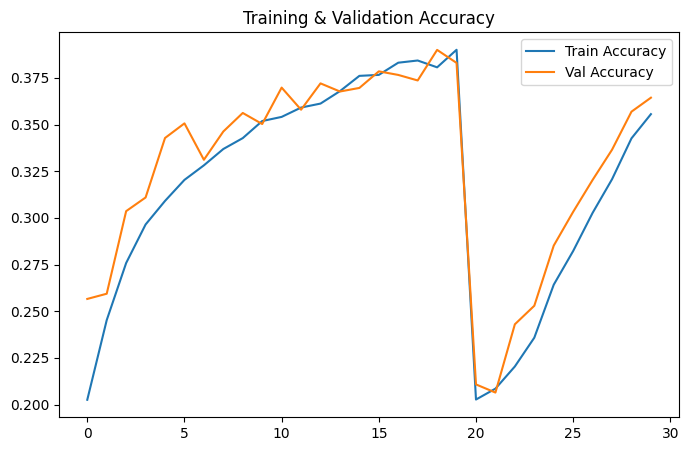

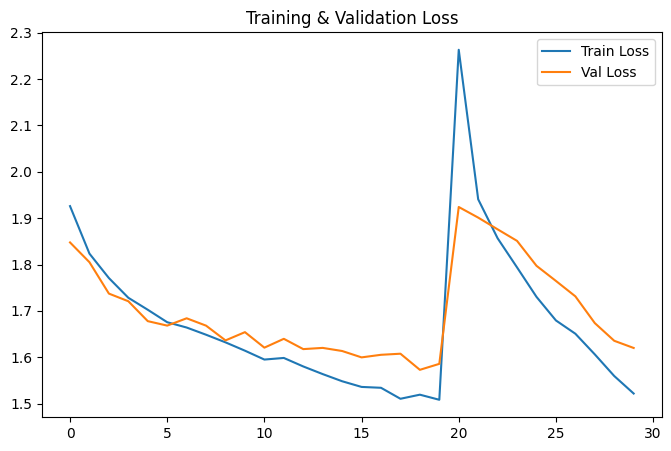

113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step

Classification Report

              precision    recall  f1-score   support

       Anger       0.27      0.14      0.19       958
     Disgust       0.10      0.63      0.17       111
        Fear       0.23      0.12      0.16      1024
       Happy       0.61      0.53      0.57      1774
     Neutral       0.38      0.44      0.41      1233
     Sadness       0.33      0.34      0.34      1247
    Surprise       0.50      0.72      0.59       831

    accuracy                           0.40      7178
   macro avg       0.35      0.42      0.35      7178
weighted avg       0.40      0.40      0.39      7178



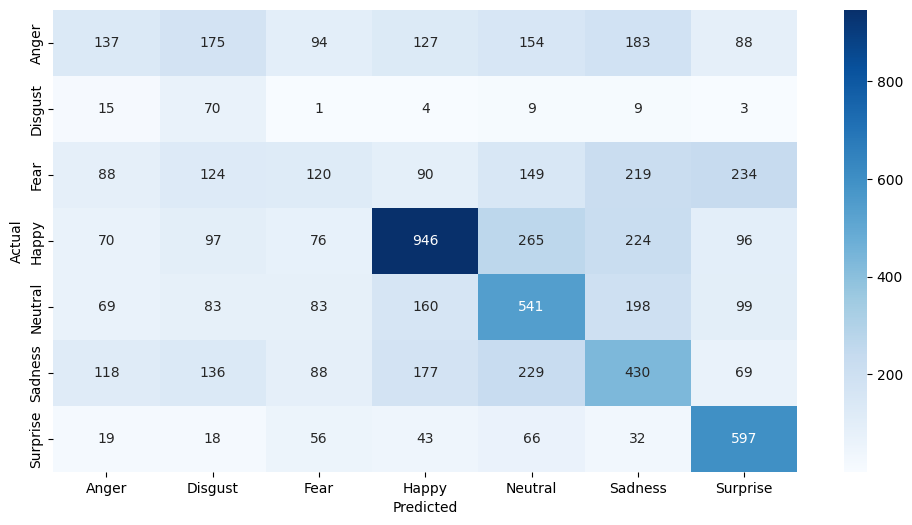

ROC-AUC Score: 0.7609440228548854


In [13]:
train_gen, val_gen, test_gen = get_data_generators()

print("Train batches:", len(train_gen))
print("Validation batches:", len(val_gen))
print("Test batches:", len(test_gen))

class_weights = get_class_weights(train_gen)
print("Class weights:", class_weights)

model = build_model()
model.summary()

history, history_fine = train_model(
    model,
    train_gen,
    val_gen,
    class_weights
)

plot_history(history, history_fine)

evaluate_model(model, test_gen)

model.save("emotion_densenet_cnn_fixed.h5")
